In [1]:
from bread.vis import *
from bread.data import Features, SegmentationFile, Microscopy
from bread.algo.lineage import LineageGuesser, LineageGuesserNN, LineageGuesserML, LineageGuesserNearestCell
from bread.algo.lineage import accuracy, align_lineages
from bread.data import Lineage

import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt

In [2]:
args = {'fov': 0, 'bud_distance_max': 12, 'num_frames_refractory': 0, 'num_frames': 8}
data_path = '../../../data/'
model_path = '/home/farzaneh/Documents/Bread/bread/src/bread/algo/lineage/saved_models/best_model_with_fake_candid_thresh12_frame_num8_normalized_False.pth'
lineage_guesses = []

# find predictions for each colony
for colony in range(0,6):
    output_file = os.path.join(data_path, f'colony00{colony}_lineage_guess.csv')
    segmentation_file = os.path.join(data_path, f'colony00{colony}_segmentation.h5')
    segmentation = SegmentationFile.from_h5(segmentation_file).get_segmentation('FOV'+str(args['fov']))
    guesser = LineageGuesserNN(
        saved_model=model_path,
        segmentation=segmentation,
        dist_threshold=args['bud_distance_max'],
        num_frames_refractory=args['num_frames_refractory'],
        num_frames=args['num_frames'],
    )

    lineage_guess: Lineage = guesser.guess_lineage()
    lineage_guesses.append(lineage_guess)
    lineage_guess.save_csv(output_file)

/home/farzaneh/Documents/Bread/bread/src/bread/data/_data.py:596: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))
/home/farzaneh/Documents/Bread/bread/src/bread/algo/lineage/_lineage.py:219: BreadWarning: cell #44 does not have nearest neighbours with a distance less than 12, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a distance less than {self.dist_threshold}, and flexible_threshold is {self.flexible_nn_threshold}.'))
/home/farzaneh/Documents/Bread/bread/src/bread/algo/lineage/_lineage.py:141: NoGuessWarning: Unable to determine parent for bud #185 in frame #122. Got error CellMissingException('Unable to find cell_id=155 at time_id=124 in the segmentation.')
  warnings.warn(LineageGuesser.NoGuessWarning(bud_id, time_id, e))
/home/farzaneh/Documents/Bread/bread/src/bread/algo/lineage/_lineage.py:953: NotEnoughFr

In [3]:
# find accuracy for each colony
for colony, lin_guess in enumerate(lineage_guesses):
    lineage_gt_path = os.path.join(data_path, f'colony00{colony}_lineage_gt.csv')
    lin_truth = Lineage.from_csv(lineage_gt_path)
    acc = accuracy(lin_truth, lin_guess, strict=False)
    print('accuracy for colony {}: {}'.format(colony , acc))
    

accuracy for colony 0: 0.8652037617554859
accuracy for colony 1: 0.9315068493150684
accuracy for colony 2: 0.8863636363636364
accuracy for colony 3: 0.8414634146341463
accuracy for colony 4: 0.8317757009345794
accuracy for colony 5: 0.9090909090909091


In [4]:
all_preds = pd.DataFrame(columns=['colony', 'bud_id', 'time_id', 'parent_gt', 'parent_pred'])
for colony, lin_guess in enumerate(lineage_guesses):
    temp_df = pd.DataFrame(columns=['colony', 'bud_id', 'time_id', 'parent_gt', 'parent_pred'])
    lineage_gt_path = os.path.join(data_path, f'colony00{colony}_lineage_gt.csv')
    lin_truth = Lineage.from_csv(lineage_gt_path)
    parent_ids_truth, parent_ids_pred, bud_ids, time_ids = align_lineages(lin_truth, lin_guess)
    temp_df['colony'] = [colony]*len(bud_ids)
    temp_df['bud_id'] = bud_ids
    temp_df['time_id'] = time_ids
    temp_df['parent_gt'] = parent_ids_truth
    temp_df['parent_pred'] = parent_ids_pred
    all_preds = pd.concat([all_preds, temp_df])

all_errors = all_preds[(all_preds['parent_gt']>0) & (all_preds['parent_pred']>0) & (all_preds['parent_gt'] != all_preds['parent_pred'])]



In [5]:
all_errors

,colony,bud_id,time_id,parent_gt,parent_pred
24,0,25,59,10,17
45,0,46,77,19,14
75,0,76,92,9,43
81,0,82,97,14,26
87,0,88,97,3,63
...,...,...,...,...,...
117,4,118,174,46,20
127,4,128,178,47,65
18,5,19,120,5,14
19,5,20,121,2,1


# Plot errors


In [14]:
def plot_features_and_save(vis,seg,time_index, bud_id, parent_id, candid_id, colony_id, save_path):
    light_green = '#90EE90'
    for i, time_id in enumerate(range(time_index,time_index+8)):
        plt.close('all')
        if(time_id >= len(seg.data)):
            break

        figax = None
        figax = plot_visible(vis, time_id, figax=figax)
        figax = plot_segmentation(seg, time_id, cellids=True, figax=figax, alpha=0.2, cell_list=[bud_id, parent_id, candid_id])
        figax = plot_debug_cell(time_id, bud_id, feat, figax=figax, color='yellow')
        figax = plot_debug_cell(time_id, parent_id, feat, figax=figax, color=light_green)
        figax = plot_debug_pair(time_id, bud_id, parent_id, feat, figax=figax, color='pink')
        # PLOT CANDIDATES
        figax = plot_debug_cell(time_id, candid_id, feat, figax=figax, color='red')
        figax = plot_debug_pair(time_id, bud_id, candid_id, feat, figax=figax, color='cyan')

        center = get_center(seg, time_id, bud_id)
        y = center[0]
        x = center[1]

        figax[1].set_xlim((x-80, x+80))
        figax[1].set_ylim((y-80, y+80))
        figax[1].set_title('colony: {}, time: {}'.format(colony_id,time_id))
        figax[0].set_dpi(140)

        figax[0].tight_layout() 

        plt.savefig(save_path+'error_c{}_bud{}_parent{}_predicted{}_t{}.png'.format(colony_id, bud_id, parent_id, candid_id, time_id))
    

/home/farzaneh/Documents/Bread/bread/src/bread/data/_data.py:596: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


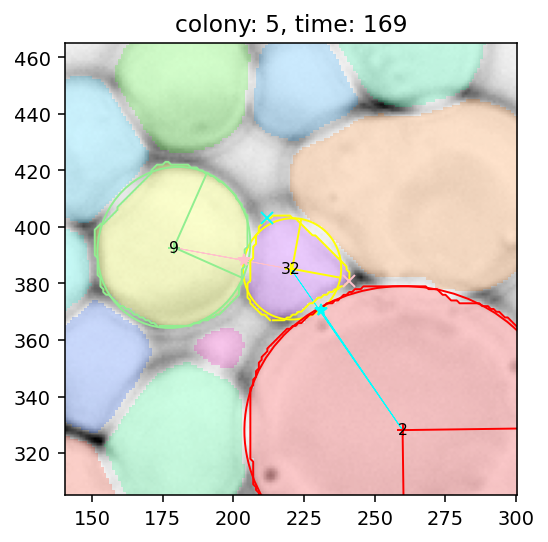

In [15]:
from bread.vis import *
from bread.data import Features, SegmentationFile, Microscopy

save_path = 'errors/'

for colony , lin_guess in enumerate(lineage_guesses):
    segmentation_file = os.path.join(data_path, f'colony00{colony}_segmentation.h5')
    seg = SegmentationFile.from_h5(segmentation_file).get_segmentation('FOV'+str(args['fov']))
    feat = Features(seg)
    vis = Microscopy.from_tiff(os.path.join(data_path, f'colony00{colony}_microscopy.tif'))
    lineage_gt_path = os.path.join(data_path, f'colony00{colony}_lineage_gt.csv')
    lin_truth = Lineage.from_csv(lineage_gt_path)
    parent_ids_truth, parent_ids_pred, bud_ids, time_ids = align_lineages(lin_truth, lin_guess)
    temp_df = pd.DataFrame(columns=['colony', 'bud_id', 'time_id', 'parent_gt', 'parent_pred'])
    temp_df['colony'] = [colony]*len(bud_ids)
    temp_df['bud_id'] = bud_ids
    temp_df['time_id'] = time_ids
    temp_df['parent_gt'] = parent_ids_truth
    temp_df['parent_pred'] = parent_ids_pred
    errors = temp_df[(temp_df['parent_gt']>0) & (temp_df['parent_pred']>0) & (temp_df['parent_gt'] != temp_df['parent_pred'])]
    for bud in errors['bud_id']:
        time_index = errors.loc[errors['bud_id']==bud, 'time_id'].values[0]
        parent_gt = errors.loc[errors['bud_id']==bud, 'parent_gt'].values[0]
        parent_pred = errors.loc[errors['bud_id']==bud, 'parent_pred'].values[0]
        plot_features_and_save(vis, seg, time_index, bud, parent_gt, parent_pred, colony, save_path)
